# **Problem Statement**

**DOMAIN:** Industrial safety. NLP based Chatbot.

**CONTEXT:** The  database  comes  from one  of  the  biggest  industry  in  Brazil  and  in  the  world.  It  is  an  urgent  need  for  industries/companies  around  the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

**DATA DESCRIPTION:** This  The  database  is  basically  records  of  accidents  from 12  different  plants  in  03  different  countries which  every  line  in  the  data  is  an occurrence of an accident.

  **Columns description:**
   - Data: timestamp or time/date information
   - Countries: which country the accident occurred (anonymised)
   - Local: the city where the manufacturing plant is located (anonymised)
   - Industry sector: which sector the plant belongs to
   - Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
   - Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)
   - Genre: if the person is male of female
   - Employee or Third Party: if the injured person is an employee or a third party
   - Critical Risk: some description of the risk involved in the accident
   - Description: Detailed description of how the accident happened.

**PROJECT OBJECTIVE:** Design  a  ML/DL  based  chatbot  utility  which  can  help  the  professionals  to  highlight  the  safety  risk  as  per  the  incident description.

## **Importing the necessary libraries**

In [84]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to use regular expressions for manipulating text data
import re

# Importing the SpaCy library
import spacy
nlp = spacy.load('en_core_web_sm')    # loading the envrionment config

# To create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# To create TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# To plot confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

# To use various metrics from sklearn
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

## **Loading the dataset**

In [85]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive') # Mounts your Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# loading data into a pandas dataframe
#accidents_data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Capstone/industrial_safety_and_health_database_with_accidents_description.xlsx")
accidents_data = pd.read_excel("https://raw.githubusercontent.com/ABHINAVRISHI1983/nlp-chat-bot/abhinav-15Sep/industrial_safety_and_health_database_with_accidents_description.xlsx", engine='openpyxl')

In [87]:
# creating a copy of the data
data = accidents_data.copy() #Good practice to preserve raw data

## **Data Overview**

### Checking the first five rows of the data

In [88]:
# Display top 5 rows
data.head(5)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."
1,1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter."
2,2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury."
3,3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury."
4,4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters high and hits the instep of the right foot of the worker, causing the injury described."


In [89]:
# Drop unnamed cols as it seems more like index or S.No
data.drop(columns=[col for col in data.columns if "Unnamed" in col], inplace=True)

In [90]:
# Display top 5 rows after dropping
data.head(5)

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter."
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury."
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury."
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters high and hits the instep of the right foot of the worker, causing the injury described."


- All records in the Description column are detailed and natural language-based.
- Potential Accident Level - ordinal classification target, looks like it is ranging from I to IV
- Critical Risk - could be multi-class or multi-label target.
-Countries, Local, Industry Sector, Genre, Employee or Third Party, Critical Risk Have limited number of categories, Could be one-hot encoded or embedded later


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Data                      425 non-null    datetime64[ns]
 1   Countries                 425 non-null    object        
 2   Local                     425 non-null    object        
 3   Industry Sector           425 non-null    object        
 4   Accident Level            425 non-null    object        
 5   Potential Accident Level  425 non-null    object        
 6   Genre                     425 non-null    object        
 7   Employee or Third Party   425 non-null    object        
 8   Critical Risk             425 non-null    object        
 9   Description               425 non-null    object        
dtypes: datetime64[ns](1), object(9)
memory usage: 33.3+ KB


- Data is datetime column
- All other columns are of type Object
- Countries, Local, Industry Sector are Categorical columns used for Geographic distribution of accidents, Industry-wise accident risk profiling
- Accident Level is Target candidate
- Genre is Likely binary (Male, Female)
- Employee or Third Party is categorical with values "Employee", "Third Party", "Third Party (Remote)"
- Critical Risk is Multi-class categorical that represents accident cause or risk factor
- Description is original accident text (rich, unstructured), can be used for NLP and Risk pattern mining

In [92]:
data['Accident Level'].value_counts()

,count
Accident Level,
I,316
II,40
III,31
IV,30
V,8


- There are 6 Accident levels

In [93]:
data['Description'].str.len().describe()

,Description
count,425.000000
mean,368.280000
std,178.944426
min,94.000000
25%,227.000000
50%,335.000000
75%,457.000000
max,1029.000000


- On average, each description is about 365 characters long
- Some are very short, some quite long with min being 94 chars and max being 1029 chars
- 25% of descriptions are shorter than 225 characters
- Median length is 334 characters — close to the mean
- 75% of the descriptions are under 453 characters
- The longest description is over 1000 characters (very detailed)

### Checking the shape of the dataset

In [94]:
#check shape of dataset
data.shape

(425, 10)

* The dataset has 425 rows and 10 columns.

### Checking for Missing Values

In [95]:
#check for missing values
data.isnull().sum()

,0
Data,0
Countries,0
Local,0
Industry Sector,0
Accident Level,0
Potential Accident Level,0
Genre,0
Employee or Third Party,0
Critical Risk,0
Description,0


* There are no missing values in the data

### Checking for duplicate values

In [96]:
# checking for duplicate values
data.duplicated().sum()

np.int64(7)

- There are 7 duplicate rows

In [97]:
# Drop duplicate rows
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [98]:
# Confirm removal
print(f"Duplicates in current dataset - {data.duplicated().sum()}")
print(f"New shape after removing duplicates: {data.shape}")

Duplicates in current dataset - 0
New shape after removing duplicates: (418, 10)


* The dataset has 418 rows and 10 columns after dropping the duplicates

## **Data Preprocessing**

### **Removing special characters**

In [99]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = re.sub(pattern, ' ', text)

    return new_text

In [100]:
# Applying the function to remove special characters
data['cleaned_text'] = data['Description'].apply(remove_special_characters)

In [101]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['Description','cleaned_text']]

,Description,cleaned_text
0,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.",While removing the drill rod of the Jumbo 08 for maintenance the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo
1,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.",During the activation of a sodium sulphide pump the piping was uncoupled and the sulfide solution was designed in the area to reach the maid Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital Note of sulphide solution 48 grams liter
2,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.",In the sub station MILPO located at level 170 when the collaborator was doing the excavation work with a pick hand tool hitting a rock with the flat part of the beak it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of the left foot of the collaborator causing the injury
3,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.",Being 9 45 am approximately in the Nv 1880 CX 695 OB7 the personnel begins the task of unlocking the Soquet bolts of the BHB machine when they were in the penultimate bolt they identified that the hexagonal head was worn proceeding Mr Crist bal Auxiliary assistant to climb to the platform to exert pressure with your hand on the DADO key to prevent it from coming out of the bolt in those moments two collaborators rotate with the lever in anti clockwise direction leaving the key of the bolt hitting the palm of the left hand causing the injury


- We can observe that regex removed the special characters ilike comma (,), equals (=), slash (/), Hiphen (-) etc.,

### **Lowercasing**

In [102]:
# changing the case of the text data to lower case
data['cleaned_text'] = data['cleaned_text'].str.lower()

In [103]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['Description','cleaned_text']]

,Description,cleaned_text
0,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.",while removing the drill rod of the jumbo 08 for maintenance the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo
1,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.",during the activation of a sodium sulphide pump the piping was uncoupled and the sulfide solution was designed in the area to reach the maid immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 grams liter
2,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.",in the sub station milpo located at level 170 when the collaborator was doing the excavation work with a pick hand tool hitting a rock with the flat part of the beak it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of the left foot of the collaborator causing the injury
3,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.",being 9 45 am approximately in the nv 1880 cx 695 ob7 the personnel begins the task of unlocking the soquet bolts of the bhb machine when they were in the penultimate bolt they identified that the hexagonal head was worn proceeding mr crist bal auxiliary assistant to climb to the platform to exert pressure with your hand on the dado key to prevent it from coming out of the bolt in those moments two collaborators rotate with the lever in anti clockwise direction leaving the key of the bolt hitting the palm of the left hand causing the injury


- We can observe that all the text has now successfully been converted to lower case.

### **Removing extra whitespace**

In [104]:
# Count rows with 2+ consecutive spaces
data['Description'].apply(lambda x: bool(re.search(r'\s{2,}', str(x)))).sum()

np.int64(0)

- There are no extra spaces found, so no need to strip the spaces, still better to have the step for any future data

In [105]:
# removing extra whitespaces from the text
data['cleaned_text'] = data['cleaned_text'].str.strip()

### **Lemmatization**

In [106]:
def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([
        token.lemma_ for token in doc
        if not token.is_punct and not token.is_space and not token.is_stop
    ])

In [107]:
# Apply on cleaned_text (not the one with stopwords already removed)
data['final_cleaned_text'] = data['cleaned_text'].apply(spacy_lemmatize)

In [108]:
# checking a couple of instances of cleaned data
data.loc[0:2, ['Description', 'cleaned_text', 'final_cleaned_text']]


,Description,cleaned_text,final_cleaned_text
0,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.",while removing the drill rod of the jumbo 08 for maintenance the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo,remove drill rod jumbo 08 maintenance supervisor proceed loosen support intermediate centralizer facilitate removal see mechanic support end drill equipment pull hand bar accelerate removal moment bar slide point support tighten finger mechanic drilling bar beam jumbo
1,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.",during the activation of a sodium sulphide pump the piping was uncoupled and the sulfide solution was designed in the area to reach the maid immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 grams liter,activation sodium sulphide pump piping uncoupled sulfide solution design area reach maid immediately use emergency shower direct ambulatory doctor later hospital note sulphide solution 48 gram liter
2,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.",in the sub station milpo located at level 170 when the collaborator was doing the excavation work with a pick hand tool hitting a rock with the flat part of the beak it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of the left foot of the collaborator causing the injury,sub station milpo locate level 170 collaborator excavation work pick hand tool hit rock flat beak bounce hit steel tip safety shoe metatarsal area left foot collaborator cause injury


We can see that the below sample words and corresponding word after applying lemmatization, This look much better that porter stemming

- removing -> remove
- proceeds -> proceed
- seeing -> see
- supports -> support

## **Model Training**

In [109]:
# Pre Settings common for all models
RANDOM_STATE = 42

### **Split train & test**

In [110]:
from sklearn.model_selection import train_test_split

# Define features & labels
X = data['final_cleaned_text'].values
y = data['Accident Level'].values

#Split train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


### Define vectorizers (BoW and TF-IDF)

In [111]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, sublinear_tf=True)

### Define evaluation function

In [112]:
# Shared results list -> final DF for comparison
RESULTS = []

In [113]:
from collections import Counter

#To Show Class imbalance
def show_class_balance(y_vec, title="Class balance"):
    cnt = Counter(y_vec)
    total = sum(cnt.values())
    df = pd.DataFrame({
        "Class": list(cnt.keys()),
        "Count": list(cnt.values()),
        "Percent": [round(100*v/total, 2) for v in cnt.values()]
    }).sort_values("Count", ascending=False).reset_index(drop=True)
    print(title)
    display(df)
    return df

In [114]:
def evaluate_and_log(model, Xtr, ytr, Xte, yte, label, results_list, show_cm=True):
    # Train the model
    model.fit(Xtr, ytr)

    # Predictions
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)

    # Metrics
    train_acc = accuracy_score(ytr, ytr_pred)
    test_acc  = accuracy_score(yte, yte_pred)
    test_f1   = f1_score(yte, yte_pred, average="macro", zero_division=0)

    # Print report
    print(f"\n{label} Results")
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Test  Accuracy: {test_acc:.3f}")
    print(f"Test  Macro-F1: {test_f1:.3f}\n")
    print(classification_report(yte, yte_pred, digits=3, zero_division=0))

    # Confusion matrix
    if show_cm:
        classes = np.unique(yte)
        cm = confusion_matrix(yte, yte_pred, labels=classes)
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=classes, yticklabels=classes,
                    cmap="Blues")
        plt.title(f"{label} - Confusion Matrix")
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.show()

    # Append to results list with consistent keys
    results_list.append({
        "Model": label,
        "Train Accuracy": round(train_acc, 3),
        "Test Accuracy": round(test_acc, 3),
        "Test Macro-F1": round(test_f1, 3)
    })


### Check class imbalance

In [115]:
_ = show_class_balance(y, title="Overall class balance")

Overall class balance


,Class,Count,Percent
0,I,309,73.92
1,II,40,9.57
2,III,31,7.42
3,IV,30,7.18
4,V,8,1.91


- The class imbalance is very high across classes

In [116]:
_ = show_class_balance(y_train, title="Train split balance")

Train split balance


,Class,Count,Percent
0,I,247,73.95
1,II,32,9.58
2,III,25,7.49
3,IV,24,7.19
4,V,6,1.80


In [117]:
_ = show_class_balance(y_test,  title="Test split balance")

Test split balance


,Class,Count,Percent
0,I,62,73.81
1,II,8,9.52
2,IV,6,7.14
3,III,6,7.14
4,V,2,2.38


- Our dataset was heavily imbalanced, with ~74% of accidents labeled as Level I while severe cases (Levels III, IV and V) had fewer than 10 examples.
- Without balancing, models tended to predict only the majority class, leading to high accuracy but poor macro-F1.
- Apply Random Oversampling on the training data to give minority classes equal representation, ensuring the model could also learn patterns from rare but critical severe accidents

### Oversampling

In [118]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=RANDOM_STATE)

### Train AdaBoost with BoW

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline


# Base (weak) learner with class_weight to help skew
weak_learner = DecisionTreeClassifier(max_depth=1, class_weight="balanced", random_state=RANDOM_STATE)

ada_params = dict(estimator=weak_learner, n_estimators=200, learning_rate=0.5, random_state=RANDOM_STATE)

# Pipelines
ada_bow_plain = ImbPipeline([
    ("bow", bow_vectorizer),
    ("clf", AdaBoostClassifier(**ada_params))
])

ada_tfidf_plain = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", AdaBoostClassifier(**ada_params))
])

ada_bow_overs = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", AdaBoostClassifier(**ada_params))
])

ada_tfidf_overs = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", AdaBoostClassifier(**ada_params))
])


AdaBoost (BoW) Results
Train Accuracy: 0.746
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



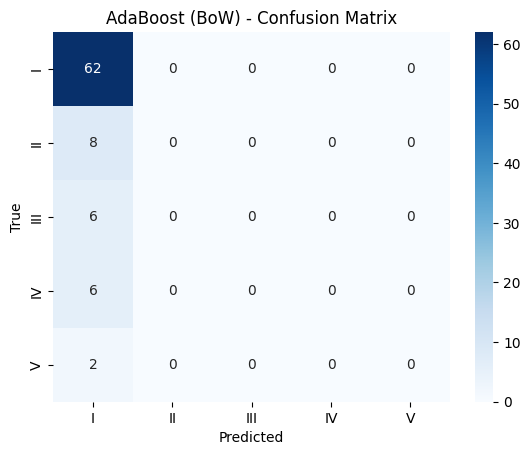

In [120]:
# Evaluate AdaBoost BoW without over sampling
evaluate_and_log(ada_bow_plain,  X_train, y_train, X_test, y_test, "AdaBoost (BoW)", RESULTS)


AdaBoost (TF-IDF) Results
Train Accuracy: 0.746
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



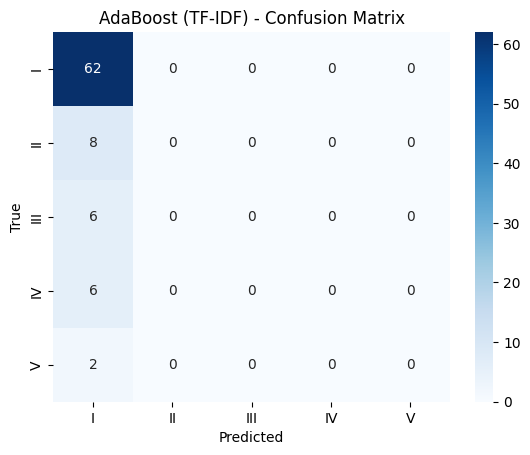

In [121]:
# Evaluate AdaBoost TFIDF without over sampling
evaluate_and_log(ada_tfidf_plain,X_train, y_train, X_test, y_test, "AdaBoost (TF-IDF)", RESULTS)


AdaBoost (BoW + Oversample) Results
Train Accuracy: 0.581
Test  Accuracy: 0.452
Test  Macro-F1: 0.253

              precision    recall  f1-score   support

           I      0.816     0.500     0.620        62
          II      0.286     0.500     0.364         8
         III      0.080     0.333     0.129         6
          IV      0.143     0.167     0.154         6
           V      0.000     0.000     0.000         2

    accuracy                          0.452        84
   macro avg      0.265     0.300     0.253        84
weighted avg      0.645     0.452     0.512        84



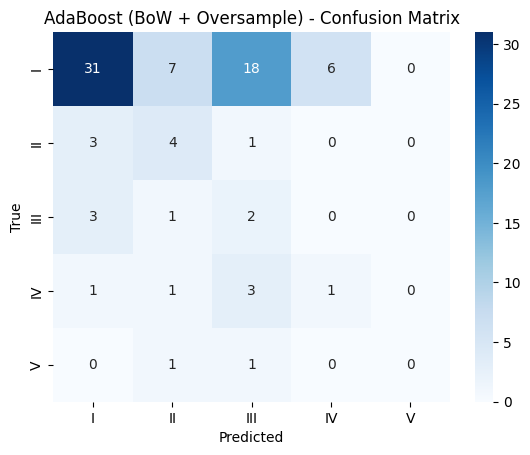

In [122]:
# Evaluate AdaBoost BoW with over sampling
evaluate_and_log(ada_bow_overs,  X_train, y_train, X_test, y_test, "AdaBoost (BoW + Oversample)", RESULTS)


AdaBoost (TF-IDF + Oversample) Results
Train Accuracy: 0.719
Test  Accuracy: 0.571
Test  Macro-F1: 0.254

              precision    recall  f1-score   support

           I      0.763     0.726     0.744        62
          II      0.000     0.000     0.000         8
         III      0.056     0.167     0.083         6
          IV      0.667     0.333     0.444         6
           V      0.000     0.000     0.000         2

    accuracy                          0.571        84
   macro avg      0.297     0.245     0.254        84
weighted avg      0.615     0.571     0.587        84



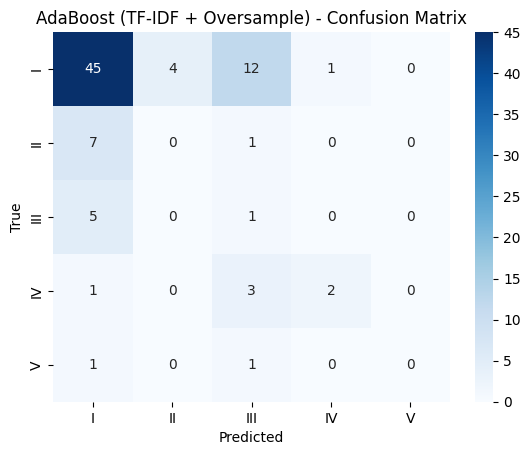

In [123]:
# Evaluate AdaBoost TFIDF with over sampling
evaluate_and_log(ada_tfidf_overs,X_train, y_train, X_test, y_test, "AdaBoost (TF-IDF + Oversample)", RESULTS)

In [124]:
# Compare Results
pd.DataFrame(RESULTS).sort_values("Test Accuracy", ascending=False)

,Model,Train Accuracy,Test Accuracy,Test Macro-F1
0,AdaBoost (BoW),0.746,0.738,0.170
1,AdaBoost (TF-IDF),0.746,0.738,0.170
3,AdaBoost (TF-IDF + Oversample),0.719,0.571,0.254
2,AdaBoost (BoW + Oversample),0.581,0.452,0.253


### Hyper-parameter tuning

In [125]:
#utility method to build base pipeline
def build_ada_pipeline(vectorizer):
    return ImbPipeline([
        (vectorizer.__class__.__name__.lower(), vectorizer),
        ("oversample", sampler),  # keep in-CV balancing
        ("clf", AdaBoostClassifier(
            estimator=DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE),
            random_state=RANDOM_STATE
        ))
    ])

In [126]:
# Hyper Parameters to be tuned
ada_grid = {
    "clf__n_estimators":  [100, 200, 400],
    "clf__learning_rate": [0.1, 0.3, 0.5, 1.0],
    "clf__estimator__max_depth": [1, 2],
    "clf__estimator__min_samples_leaf": [1, 2]
}

#### Hyper parameter tuning for Bow

In [127]:
from sklearn.model_selection import StratifiedKFold

# Define a stratified 5-fold cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [128]:
from sklearn.model_selection import GridSearchCV


# Build the AdaBoost pipeline using Bag-of-Words features
pipe_bow   = build_ada_pipeline(bow_vectorizer)

# Set up GridSearchCV for hyperparameter tuning
grid_bow = GridSearchCV(
    estimator=pipe_bow,
    param_grid=ada_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"  # fail fast if something is wrong
)

# Run the grid search on the training data
grid_bow.fit(X_train, y_train)

print("Best BoW params:", grid_bow.best_params_, "CV Macro-F1:", round(grid_bow.best_score_, 3))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best BoW params: {'clf__estimator__max_depth': 2, 'clf__estimator__min_samples_leaf': 2, 'clf__learning_rate': 1.0, 'clf__n_estimators': 400} CV Macro-F1: 0.671


#### Hyper parameter tuning for TF-IDF

In [129]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Build the AdaBoost pipeline using TDIDF features
pipe_tfidf = build_ada_pipeline(tfidf_vectorizer)

# Set up GridSearchCV for hyperparameter tuning
grid_tfidf = GridSearchCV(
    estimator=pipe_tfidf,
    param_grid=ada_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
)

# Run the grid search on the training data
grid_tfidf.fit(X_train, y_train)

print("Best TF-IDF params:", grid_tfidf.best_params_, "CV Macro-F1:", round(grid_tfidf.best_score_, 3))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best TF-IDF params: {'clf__estimator__max_depth': 2, 'clf__estimator__min_samples_leaf': 2, 'clf__learning_rate': 1.0, 'clf__n_estimators': 400} CV Macro-F1: 0.695



AdaBoost (BoW + TUNED) Results
Train Accuracy: 0.922
Test  Accuracy: 0.619
Test  Macro-F1: 0.236

              precision    recall  f1-score   support

           I      0.746     0.806     0.775        62
          II      0.111     0.125     0.118         8
         III      0.000     0.000     0.000         6
          IV      1.000     0.167     0.286         6
           V      0.000     0.000     0.000         2

    accuracy                          0.619        84
   macro avg      0.371     0.220     0.236        84
weighted avg      0.633     0.619     0.604        84



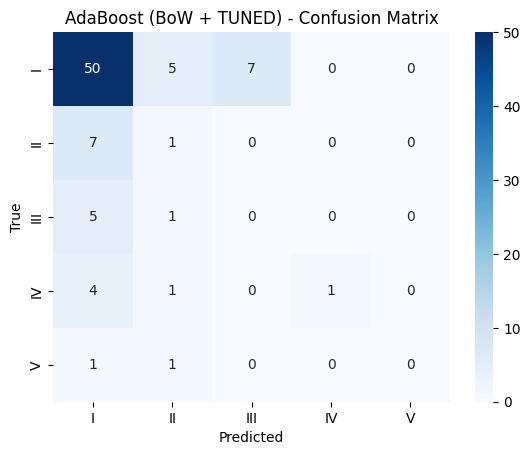

In [130]:
#Evaluate AdaBoost with BoW + Tuned
_ = evaluate_and_log(grid_bow.best_estimator_,   X_train, y_train, X_test, y_test,
                     "AdaBoost (BoW + TUNED)", RESULTS)


AdaBoost (TF-IDF + TUNED) Results
Train Accuracy: 0.964
Test  Accuracy: 0.607
Test  Macro-F1: 0.156

              precision    recall  f1-score   support

           I      0.739     0.823     0.779        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.607        84
   macro avg      0.148     0.165     0.156        84
weighted avg      0.546     0.607     0.575        84



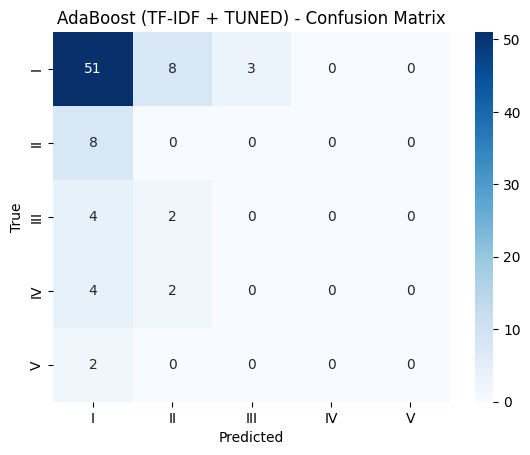

In [131]:
#Evaluate AdaBoost with TF-IDF + Tuned
_ = evaluate_and_log(grid_tfidf.best_estimator_, X_train, y_train, X_test, y_test,
                     "AdaBoost (TF-IDF + TUNED)", RESULTS)

In [132]:
#Compare results
final_df = pd.DataFrame(RESULTS).sort_values(["Test Accuracy"], ascending=False).reset_index(drop=True)
display(final_df)

,Model,Train Accuracy,Test Accuracy,Test Macro-F1
0,AdaBoost (BoW),0.746,0.738,0.170
1,AdaBoost (TF-IDF),0.746,0.738,0.170
2,AdaBoost (BoW + TUNED),0.922,0.619,0.236
3,AdaBoost (TF-IDF + TUNED),0.964,0.607,0.156
4,AdaBoost (TF-IDF + Oversample),0.719,0.571,0.254
5,AdaBoost (BoW + Oversample),0.581,0.452,0.253


- Based on Accuracy, AdaBoost (BoW / TF-IDF base) seems better (0.738) along with AdaBoost (BoW)

### SVM Model Starts

In [133]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline

# Define SVM model
svm = SVC(kernel='poly', degree=3, random_state=RANDOM_STATE) # Added random_state for reproducibility

# Pipelines for SVM
svm_bow_plain = ImbPipeline([
    ("bow", bow_vectorizer),
    ("clf", svm)
])

svm_tfidf_plain = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", svm)
])

svm_bow_overs = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", svm)
])

svm_tfidf_overs = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", svm)
])


SVM (BoW) Results
Train Accuracy: 0.850
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



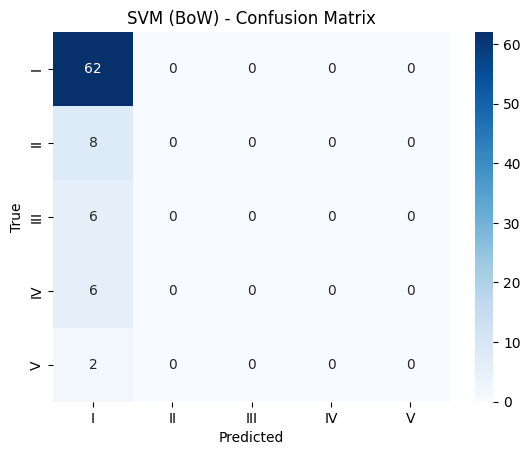

In [134]:
# Evaluate AdaBoost BoW without over sampling
evaluate_and_log(svm_bow_plain,  X_train, y_train, X_test, y_test, "SVM (BoW)", RESULTS)


SVM (TF-IDF) Results
Train Accuracy: 0.991
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



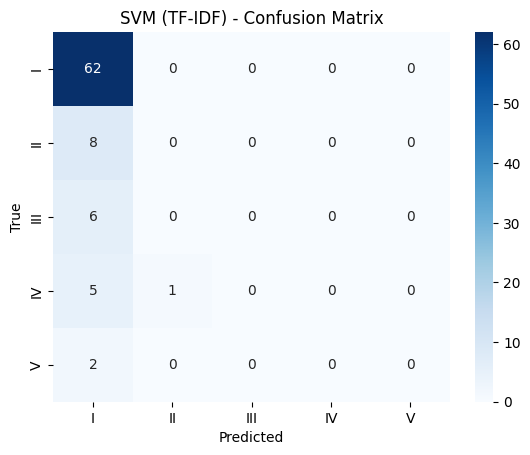

In [135]:
# Evaluate AdaBoost TFIDF without over sampling
evaluate_and_log(svm_tfidf_plain,X_train, y_train, X_test, y_test, "SVM (TF-IDF)", RESULTS)


SVM (BoW + Oversample) Results
Train Accuracy: 0.958
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



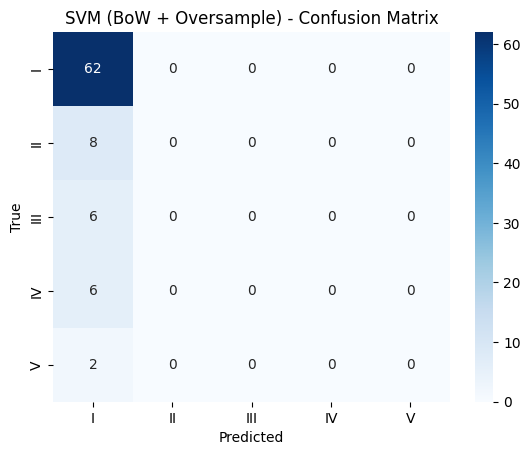

In [136]:
# Evaluate AdaBoost BoW with over sampling
evaluate_and_log(svm_bow_overs,  X_train, y_train, X_test, y_test, "SVM (BoW + Oversample)", RESULTS)


SVM (TF-IDF + Oversample) Results
Train Accuracy: 0.991
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



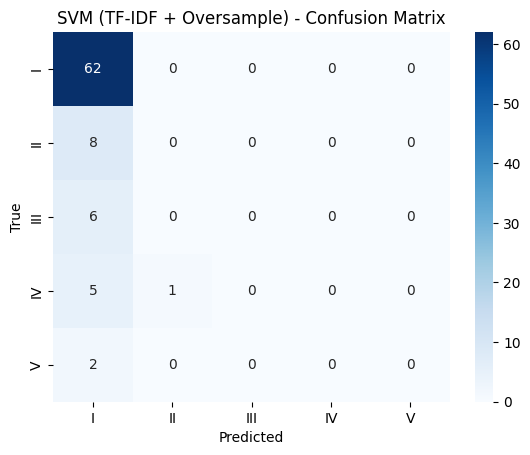

In [137]:
# Evaluate AdaBoost TFIDF with over sampling
evaluate_and_log(svm_tfidf_overs,X_train, y_train, X_test, y_test, "SVM (TF-IDF + Oversample)", RESULTS)

In [145]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline

# Define SVM model
svm_gamma = SVC(kernel='poly', degree=3, gamma=0.3,C=0.1, random_state=RANDOM_STATE) # Added random_state for reproducibility

# Pipelines for SVM
svm_bow_plain_gamma = ImbPipeline([
    ("bow", bow_vectorizer),
    ("clf", svm_gamma)
])

svm_tfidf_plain_gamma = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", svm_gamma)
])

svm_bow_overs_gamma = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", svm_gamma)
])

svm_tfidf_overs_gamma = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", svm_gamma)
])


SVM GAMMA (BoW) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



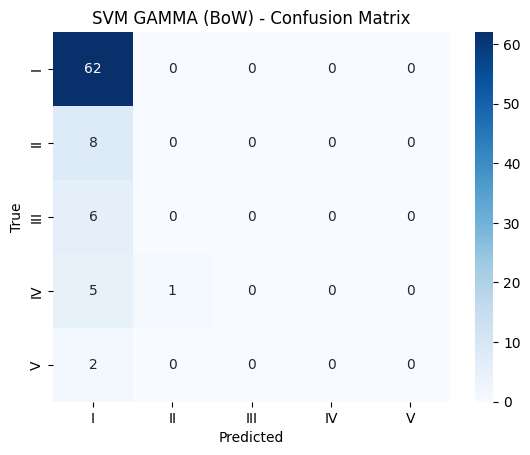

In [146]:
# Evaluate AdaBoost BoW without over sampling
evaluate_and_log(svm_bow_plain_gamma,  X_train, y_train, X_test, y_test, "SVM GAMMA (BoW)", RESULTS)


SVM GAMMA (TF-IDF) Results
Train Accuracy: 0.740
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



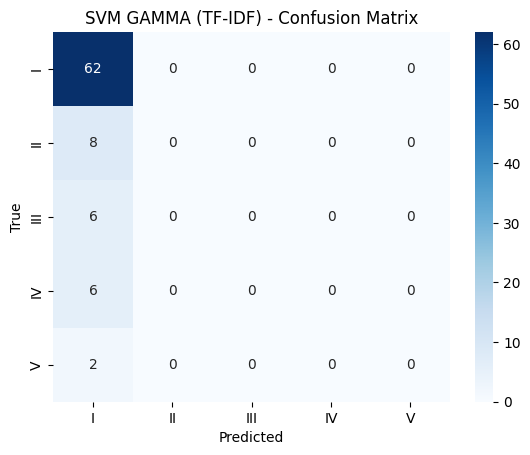

In [147]:
# Evaluate AdaBoost TFIDF without over sampling
evaluate_and_log(svm_tfidf_plain_gamma,X_train, y_train, X_test, y_test, "SVM GAMMA (TF-IDF)", RESULTS)


SVM GAMMA (BoW + Oversample) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



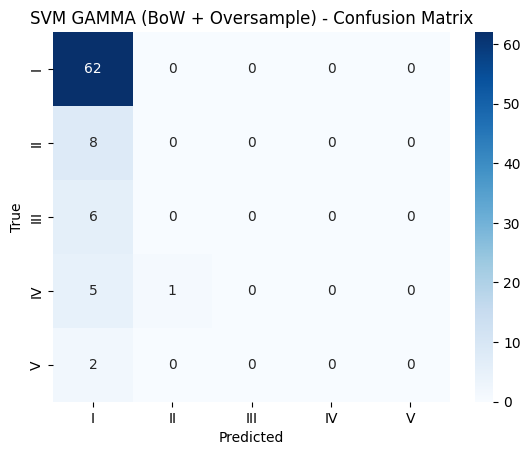

In [148]:
# Evaluate AdaBoost BoW with over sampling
evaluate_and_log(svm_bow_overs_gamma,  X_train, y_train, X_test, y_test, "SVM GAMMA (BoW + Oversample)", RESULTS)


SVM (TF-IDF + Oversample) Results
Train Accuracy: 0.958
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



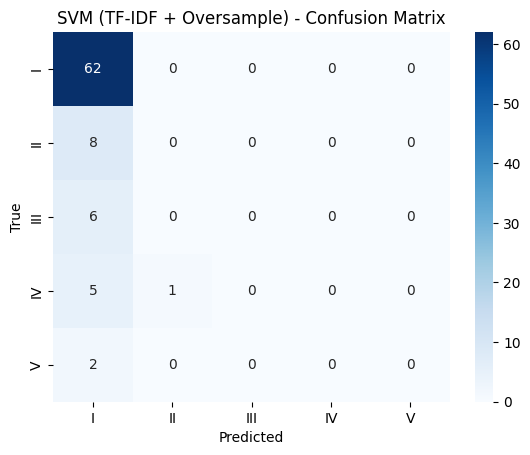

In [149]:
# Evaluate AdaBoost TFIDF with over sampling
evaluate_and_log(svm_tfidf_overs_gamma,X_train, y_train, X_test, y_test, "SVM (TF-IDF + Oversample)", RESULTS)

In [150]:
# Compare Results
pd.DataFrame(RESULTS).sort_values("Test Accuracy", ascending=False)

,Model,Train Accuracy,Test Accuracy,Test Macro-F1
0,AdaBoost (BoW),0.746,0.738,0.170
1,AdaBoost (TF-IDF),0.746,0.738,0.170
9,SVM (TF-IDF + Oversample),0.991,0.738,0.171
8,SVM (BoW + Oversample),0.958,0.738,0.170
7,SVM (TF-IDF),0.991,0.738,0.171
6,SVM (BoW),0.850,0.738,0.170
13,SVM (TF-IDF + Oversample),0.958,0.738,0.171
12,SVM GAMMA (BoW + Oversample),0.994,0.738,0.171
11,SVM GAMMA (TF-IDF),0.740,0.738,0.170
10,SVM GAMMA (BoW),0.994,0.738,0.171
